<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Build and Save a Spark model to DSX Repository</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
</table>

This notebook walks you through these steps:
 
- Access the data
- Cleanse data for analysis
- Explore data
- Build a classification model
- Save the model in the DSX repository with associated meta data


### Step 1: Download Data as Spark Dataframe from Local Storage

Read the three Mortgage files from local storage - Insert them as SPARK Dataframes

In [22]:
import os
from pyspark.sql import SQLContext
# Add asset from file system
df_data_1 = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/MortgageCustomer.csv', header='true', inferSchema = 'true')

In [2]:
# Add asset from file system
df_data_2 = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Property.csv', header='true', inferSchema = 'true')

In [3]:
# Add asset from file system
df_data_3 = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Default.csv', header='true', inferSchema = 'true')

In [4]:
customer = df_data_1
property = df_data_2
default = df_data_3

In [5]:
customer.cache()
property.cache()
default.cache()

DataFrame[ID: double, MortgageDefault: string]

View the data within the three data frames created above. 

In [6]:
customer.show(5)
#property.show(5)
#default.show(5)

+--------+-------+-------------+--------------+----------------------+-------------------------+---------------+---------------+-----+-----------+
|      ID| Income|AppliedOnline|     Residence|Yrs at Current Address|Yrs with Current Employer|Number of Cards|Creditcard Debt|Loans|Loan Amount|
+--------+-------+-------------+--------------+----------------------+-------------------------+---------------+---------------+-----+-----------+
|100522.0|43982.0|          YES|Owner Occupier|                  13.0|                     11.0|            2.0|         1055.0|  0.0|     9405.0|
|101756.0|59944.0|          YES|Owner Occupier|                  20.0|                     11.0|            2.0|         3894.0|  0.0|     9880.0|
|101354.0|57718.0|          YES|Owner Occupier|                  25.0|                     16.0|            2.0|         1555.0|  1.0|     6285.0|
|100512.0|45621.0|          YES|Owner Occupier|                   1.0|                     19.0|            1.0|      

### Step 2: Merge Files

In [7]:
# Join the Customer, Property and Default tables together with ID being the key field.
# Keep all fields from the Customer and Default tables but only SalePrice and Location from the Property table

merged = customer.join(property, customer['ID'] == property['ID'])\
                   .join(default, customer['ID']==default['ID'])\
                   .select(customer['ID'],customer['Income'],customer['AppliedOnline'],customer['Residence'],\
                           customer['Yrs at Current Address'],customer['Yrs with Current Employer'],customer['Number of Cards'],\
                           customer['Creditcard Debt'],customer['Loans'],customer['Loan Amount'],\
                           property['SalePrice'], property['Location'], default['MortgageDefault'])

# Preview  5 rows
merged.toPandas().head()

ID   Income AppliedOnline       Residence  Yrs at Current Address  \
0  100522.0  43982.0           YES  Owner Occupier                    13.0   
1  101756.0  59944.0           YES  Owner Occupier                    20.0   
2  101354.0  57718.0           YES  Owner Occupier                    25.0   
3  100512.0  45621.0           YES  Owner Occupier                     1.0   
4  100537.0  45081.0            NO  Owner Occupier                    14.0   

   Yrs with Current Employer  Number of Cards  Creditcard Debt  Loans  \
0                       11.0              2.0           1055.0    0.0   
1                       11.0              2.0           3894.0    0.0   
2                       16.0              2.0           1555.0    1.0   
3                       19.0              1.0           1878.0    0.0   
4                       15.0              2.0            713.0    1.0   

   Loan Amount  SalePrice  Location MortgageDefault  
0       9405.0     500000       110              NO  
1       9880.0     750000       110              NO  
2       6285.0     155000       130             YES  
3       9260.0     195000       100             YES  
4       8430.0     140000       110              NO

### Step 3: Simple Data Preparation - Rename some columns and ensure correct data types 
This step is to remove spaces from columns names

In [8]:
merged = merged.withColumnRenamed("Yrs at Current Address", "YearCurrentAddress").withColumnRenamed("Yrs with Current Employer","YearsCurrentEmployer")\
                .withColumnRenamed("Number of Cards","NumberOfCards").withColumnRenamed("Creditcard Debt","CCDebt").withColumnRenamed("Loan Amount", "LoanAmount")
merged.toPandas().head(3)

ID   Income AppliedOnline       Residence  YearCurrentAddress  \
0  100522.0  43982.0           YES  Owner Occupier                13.0   
1  101756.0  59944.0           YES  Owner Occupier                20.0   
2  101354.0  57718.0           YES  Owner Occupier                25.0   

   YearsCurrentEmployer  NumberOfCards  CCDebt  Loans  LoanAmount  SalePrice  \
0                  11.0            2.0  1055.0    0.0      9405.0     500000   
1                  11.0            2.0  3894.0    0.0      9880.0     750000   
2                  16.0            2.0  1555.0    1.0      6285.0     155000   

   Location MortgageDefault  
0       110              NO  
1       110              NO  
2       130             YES

Check data types and re-cast numeric fields to **Integers**

In [9]:
merged.dtypes

[('ID', 'double'),
 ('Income', 'double'),
 ('AppliedOnline', 'string'),
 ('Residence', 'string'),
 ('YearCurrentAddress', 'double'),
 ('YearsCurrentEmployer', 'double'),
 ('NumberOfCards', 'double'),
 ('CCDebt', 'double'),
 ('Loans', 'double'),
 ('LoanAmount', 'double'),
 ('SalePrice', 'int'),
 ('Location', 'int'),
 ('MortgageDefault', 'string')]

In [10]:
merged = merged.select(merged.ID.cast("integer"),merged.Income.cast('integer'),merged.AppliedOnline,merged.Residence,\
                   merged.YearCurrentAddress.cast('integer'),merged.YearsCurrentEmployer.cast('integer'),\
                   merged.NumberOfCards.cast('integer'),merged.CCDebt.cast('integer'),merged.Loans.cast('integer'),\
                   merged.LoanAmount.cast('integer'),merged.SalePrice,merged.Location,merged.MortgageDefault)
merged.dtypes

[('ID', 'int'),
 ('Income', 'int'),
 ('AppliedOnline', 'string'),
 ('Residence', 'string'),
 ('YearCurrentAddress', 'int'),
 ('YearsCurrentEmployer', 'int'),
 ('NumberOfCards', 'int'),
 ('CCDebt', 'int'),
 ('Loans', 'int'),
 ('LoanAmount', 'int'),
 ('SalePrice', 'int'),
 ('Location', 'int'),
 ('MortgageDefault', 'string')]

### Step 4: Data Exploration

1) Obtain some data shape summaries in terms of number of fields and records <br>
2) Perform some exploratory analysis of distributions, scatterplots using two different graphics packages

#### Feel free to play around with the charts to explore other features that are in the data set

In [11]:
print "There are " + str(len(merged.toPandas())) + " records and " + str(len(merged.toPandas().columns)) + " fields in the dataset."

There are 419 records and 13 fields in the dataset.


In [12]:
import brunel
df = merged.toPandas()
%brunel data('df') bar x(Residence) y(Income) mean(CCDebt) color(MortgageDefault) stack tooltip(Income) | x(YearCurrentAddress) y(YearsCurrentEmployer) point color(MortgageDefault) tooltip(YearCurrentAddress, YearsCurrentEmployer) :: width=1100, height=400 

<IPython.core.display.Javascript object>


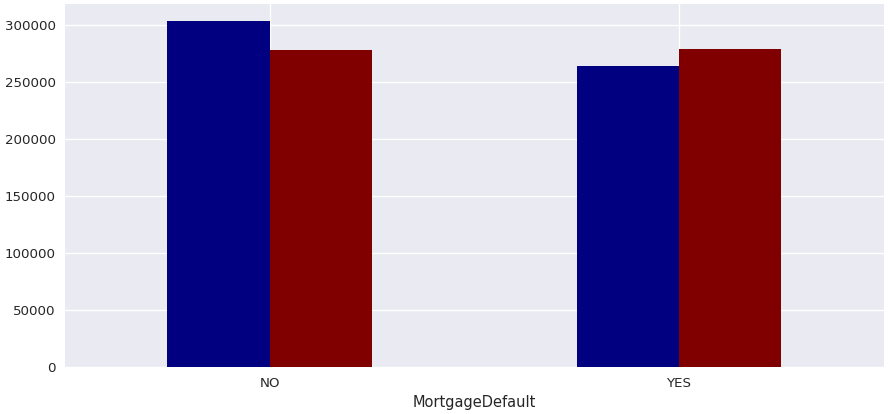

In [ ]:
from pixiedust.display import *
display(merged)

### Step 5: Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [14]:
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the algorithm
stringIndexer1 = StringIndexer(inputCol='AppliedOnline', outputCol='AppliedOnlineEncoded')
stringIndexer2 = StringIndexer(inputCol='Residence',outputCol='ResidenceEncoded')
stringIndexer3 = StringIndexer(inputCol='MortgageDefault', outputCol='label')

# Instanciate the algorithm
rf=RandomForestClassifier(labelCol="label", featuresCol="features")


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["Income", "AppliedOnlineEncoded", "ResidenceEncoded", "YearCurrentAddress", "YearsCurrentEmployer", "NumberOfCards", \
                                       "CCDebt", "Loans", "LoanAmount", "SalePrice", "Location"], outputCol="features")

pipeline = Pipeline(stages=[stringIndexer1, stringIndexer2, stringIndexer3, assembler, rf])

In [15]:
# Split data into train and test datasets
train, test = merged.randomSplit([80.0,20.0], seed=6)

In [16]:
# Build model based upon the pipeline defined in the above cell
model = pipeline.fit(train)

### Step 6: Score the test data set

In [17]:
results = model.transform(test)
results.toPandas().head(3)

ID  Income AppliedOnline       Residence  YearCurrentAddress  \
0  100282   45715           YES  Owner Occupier                   8   
1  100284   45049           YES  Public Housing                   6   
2  100285   44974           YES  Public Housing                  14   

   YearsCurrentEmployer  NumberOfCards  CCDebt  Loans  LoanAmount  SalePrice  \
0                    14              2     772      1       12985     137000   
1                    16              2    1345      1        9085     280000   
2                    18              2    2772      0        9515     264000   

   Location MortgageDefault  AppliedOnlineEncoded  ResidenceEncoded  label  \
0       100              NO                   0.0               0.0    0.0   
1       110              NO                   0.0               2.0    0.0   
2       130              NO                   0.0               2.0    0.0   

                                            features  \
0  [45715.0, 0.0, 0.0, 8.0, 14.0, 2.0, 772.0, 1.0...   
1  [45049.0, 0.0, 2.0, 6.0, 16.0, 2.0, 1345.0, 1....   
2  [44974.0, 0.0, 2.0, 14.0, 18.0, 2.0, 2772.0, 0...   

                             rawPrediction  \
0  [15.643518364742024, 4.356481635257976]   
1  [9.332057086046674, 10.667942913953326]   
2   [10.693051215755451, 9.30694878424455]   

                                 probability  prediction  
0  [0.7821759182371012, 0.21782408176289877]         0.0  
1   [0.4666028543023337, 0.5333971456976663]         1.0  
2  [0.5346525607877726, 0.46534743921222754]         0.0

### Step 7: Model Evaluation 

In [18]:
print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))

Precision model1 = 0.63.


In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))

Area under ROC curve = 0.63.


In [20]:
evaluatorRF = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
accuracy = evaluatorRF.evaluate(results)

print("Accuracy = %g" % accuracy)

Accuracy = 0.625


### Step 8: Save Model in ML repository


In [21]:
from dsx_ml.ml import save

model_name = "Predict Mortgage Default LOS"
save(name = model_name,
     model = model,
     algorithm_type = 'Classification',
     test_data = test)

Using TensorFlow backend.


{'path': '/user-home/1003/DSX_Projects/DSX_Demos_0710/models/Predict Mortgage Default LOS/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Demos_0710/Predict%20Mortgage%20Default%20LOS/1'}

## Summary:
You are now at the end of Lab 1 and should have successfully:
- Loaded data 
- Performed basic data preparation on the loaded data
- Explored the data graphically
- Build a Spark Model in the form of a pipeline
- Evaluated the model for accuracy levels
- Stored the model in to the IBM ML environment in readiness for deployment

---------------------------------------------------------------------------------
Author Information:<br>
**Stephen Groves** based on an original notebook created by Sidney Phoon, IBM USA
<br/>
steve.groves@uk.ibm.com
<br/>
9th April 2018